# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Visualizations will be shown in the notebook.
%matplotlib inline

import os
import collections
import random
import pickle
import numpy as np
import math
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2

from PIL import Image

In [2]:
def show_image(image, cmap=None):
    
    if(cmap == 'gray'):
        plt.figure(figsize=(5,5))
        plt.imshow(image, cmap='gray')
    
    else:
        plt.figure(figsize=(5,5))
        plt.imshow(image)


def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    img = augment_brightness_camera_images(img)
    
    return img


def load_pickle(filename, directory='.'):   
    with open(filename, 'rb') as f:
         data = pickle.load(f)
    return data


def save_pickle(dataset, filename, keys = "features", directory='.'):

    pickle_file = filename
    
    try:
        f = open(pickle_file,'wb+')
        save = {
#            "features": X_train
            "features": dataset
    }
  
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    except Exception as e:
          print('Unable to save data to', pickle_file, ':', e)

            
def make_fakes(data,no_of_fakes):
    
    data_no = len(data) * no_of_fakes
    
    new_data = []
           
    for index in range(data.shape[0]):
    
        for fake in range(no_of_fakes):
#           print(data[index])
            
            fake = transform_image(data[index],20,10,5)
#           print("fake shape %s" % str(fake.shape))
#           print(type(fake))
            
            new_data.append(fake)        
                       
    return new_data

def make_fakes_labels(data,no_of_fakes):
    data_no = len(data)
    
    new_data = []
    
    for index in range(data.shape[0]):
        
        for fake in range(no_of_fakes):
            
            fake = data[index]
            
            new_data.append(fake)
            
    return new_data
    

def list_to_numpy(list_data):
    
    return np.array(list_data)


def load_pickle_with_fakes(orignal_pickle,no_of_fakes, directory='.'):
    
    pickle_file = orignal_pickle
    
    original = load_pickle(pickle_file)
    
    X_train = original['features']
    
    fakes = make_fakes(X_train,no_of_fakes)
    
    X_train_norm = list_to_numpy(fakes)
    
    
    save_pickle(X_train_norm,"X_train_fake.p")

    data_norm = load_pickle('X_train_fake.p')
    
    # TODO: Load the label data to the variable y_train
    y_train = original['labels']
    
    fakes_label = make_fakes_labels(y_train,5)
    
    y_train_norm = list_to_numpy(fakes_label)
    
    save_pickle(y_train_norm,"y_train_fake.p")

    label_norm = load_pickle('y_train_fake.p')
    
    return data_norm, label_norm

def split_data(data, label, split = 0.3):
    
    X_train, X_valid, y_train, y_valid = train_test_split(
    data,
    label,
    test_size=split,
    random_state=832289)
    
    return X_train, X_valid, y_train, y_valid


def load_resized_images_in_directory(width,height,dirname):
    
    image_list = os.listdir(dirname)

    y_data = np.array(image_list)
    y_data2 = np.char.rstrip(y_data,'.jpg')
    y_web = y_data2.astype(np.uint8)
    
    X_web = np.array([cv2.resize(np.array(mpimg.imread(imagedir + fname)),(32,32)) 
                  for fname in image_list])
    
    return X_web, y_web
    

def resize_image(image, width, height):
    
    return cv2.resize(np.array(image),(width,height))

def load_images_in_directory(dirname):
    
    image_list = os.listdir(dirname)

    y_data = np.array(image_list)
    y_data2 = np.char.rstrip(y_data,'.jpg')
    y_web = y_data2.astype(np.uint8)

#    print(y_train[:5])

#    print(y_web[:])
    
    X_web = np.array([mpimg.imread(imagedir + fname) for fname in image_list])
    
    return X_web, y_web

In [3]:
X_train_fake, y_train_fake = load_pickle_with_fakes('train.p',5)

In [4]:
X_train = X_train_fake['features']
y_train = y_train_fake['features']

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)


test = load_pickle('test.p')
X_test = test['features']
y_test = test['labels']


# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("number of classes ", n_classes)
#print("coords_train =", coords_train)
#print("size_train =", size_train)

Number of training examples = 196045
Number of testing examples = 12630
Image data shape = (32, 32, 3)
number of classes  43


In [5]:
X_train, X_valid, y_train, y_valid = split_data(X_train,y_train)

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)
n_train_label = len(y_train)

# TODO: Number of testing examples.
n_valid = len(X_valid)
n_valid_label = len(y_valid)


print("Number of training examples =", n_train)
print(n_train_label )
print("Number of validation examples =", n_valid)
print(n_valid_label)


Number of training examples = 137231
137231
Number of validation examples = 58814
58814


In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.5
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 8), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(8))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    conv1_relu = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1_pool = tf.nn.max_pool(conv1_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 8, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    conv2_relu = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2_pool = tf.nn.max_pool(conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Flatten. Input = 8x8x32. Output = 2048.
#    fc0   = flatten(conv2_pool)
    
    conv1_pool_flat = tf.reshape( conv1_pool, [-1, 16 * 16 * 8])
    conv2_pool_flat = tf.reshape( conv2_pool, [-1, 8 * 8 * 16])
    fc0 = tf.concat(1,[ conv1_pool_flat , conv2_pool_flat])
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 2048. Output = 120.
    # SOLUTION: Layer 3: Fully Connected. Input = 6144. Output = 120.
     # SOLUTION: Layer 3: Fully Connected. Input = 3072. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(3072, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1_relu    = tf.nn.relu(fc1)

#    fc1_drop =  tf.nn.dropout(  fc1_relu , keep_prob)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits    = tf.matmul( fc1_relu, fc2_W) + fc2_b
    
    return logits

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [8]:
rate = 0.001

logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 5
BATCH_SIZE = 128
# Initializing the variables
init = tf.global_variables_initializer()

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
topk_operation = tf.nn.top_k(logits, k=3)

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



def evaluate_topk(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        topk = sess.run(topk_operation, feed_dict={x: batch_x, y: batch_y})
       
    return topk

In [11]:

with tf.Session() as sess:
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if(i == (EPOCHS-1) ):
            test_accuracy = evaluate(X_test, y_test)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
        
        print()
        
    saver.save(sess, "./lenet/model.ckpt")
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.168

EPOCH 2 ...
Validation Accuracy = 0.309

EPOCH 3 ...
Validation Accuracy = 0.391

EPOCH 4 ...
Validation Accuracy = 0.445

EPOCH 5 ...
Validation Accuracy = 0.470
EPOCH 5 ...
Test Accuracy = 0.514

Model saved


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Include an exploratory visualization of the dataset

In [12]:
with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, "./lenet/model.ckpt")
    
    print("restored...")
    
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if(i == (EPOCHS-1) ):
            test_accuracy = evaluate(X_test, y_test)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
        
        print()

restored...
Training...
EPOCH 1 ...
Validation Accuracy = 0.508

EPOCH 2 ...
Validation Accuracy = 0.533

EPOCH 3 ...
Validation Accuracy = 0.566

EPOCH 4 ...
Validation Accuracy = 0.572

EPOCH 5 ...
Validation Accuracy = 0.602
EPOCH 5 ...
Test Accuracy = 0.602



In [13]:
imagedir = "./data/"

X_web,y_web = load_resized_images_in_directory(32,32,imagedir)

In [14]:
### Run the predictions here and use the model to output the prediction for each image.
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, "./lenet/model.ckpt")
    
    print("restored...")
    
    num_examples = len(X_web)
    
    print("Training...")
    for i in range(EPOCHS):
        X_web, y_web = shuffle(X_web, y_web)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_web[offset:end], y_web[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
#        validation_accuracy = evaluate(X_valid, y_valid)
#        print("EPOCH {} ...".format(i+1))
#        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if(i == (EPOCHS-1) ):
            test_accuracy = evaluate(X_web, y_web)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            
            test = evaluate_topk(X_web, y_web)
            print(test)

sess.close()

restored...
Training...
EPOCH 5 ...
Test Accuracy = 0.400
TopKV2(values=array([[  0.76447433,   0.56847322,   0.4943786 ],
       [ 10.9986763 ,   7.98646832,   7.92214298],
       [  0.76447433,   0.56847322,   0.4943786 ],
       [  0.76447433,   0.56847322,   0.4943786 ],
       [ 27.47885895,  24.17716599,  23.84058571]], dtype=float32), indices=array([[12, 38, 10],
       [13,  1,  2],
       [12, 38, 10],
       [12, 38, 10],
       [38, 34, 40]], dtype=int32))


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


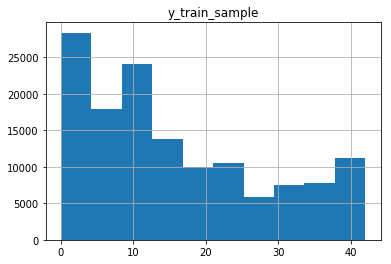

In [15]:
distribution =pd.DataFrame({"y_train_sample":y_train})
distribution.hist(layout=(1,1))  

traffic_signs = pd.read_csv("signnames.csv")
traffic_signs[:5]

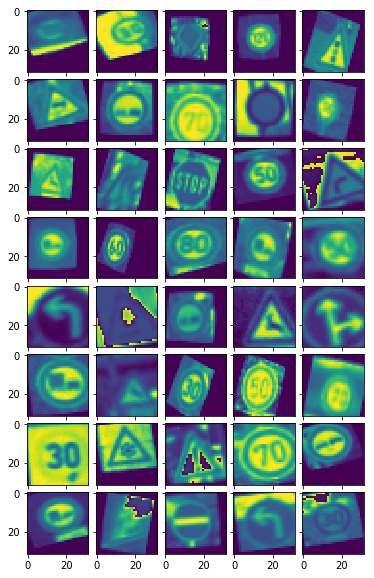

[89993, 82091, 99297, 77128, 93196, 4859, 99444, 26883, 104709, 94836, 112402, 55917, 17099, 51874, 98028, 133111, 73141, 101194, 131591, 55466, 117147, 74565, 62830, 13731, 24217, 17589, 73585, 75897, 122482, 125798, 60260, 34585, 45757, 78032, 110031, 108504, 117607, 132042, 132818, 126904]
[7, 5, 12, 8, 26, 23, 9, 4, 15, 8, 31, 18, 14, 2, 20, 10, 3, 5, 10, 2, 34, 11, 9, 31, 36, 10, 31, 1, 2, 4, 1, 30, 18, 4, 9, 10, 25, 17, 34, 1]


In [16]:
sample_locs = []
sample_labels = []
random_size = n_train


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)



def get_image(data, label):
    maybe_image = random.randint(0,random_size)
    sample_locs.append(maybe_image)
    sample_labels.append(label[maybe_image])
#    print('maybe_image %s: ' % maybe_image)
#    print('label value is %s' % label[maybe_image])
        
    return data[maybe_image]


fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                  )

for i in range(40):
    maybe_image = get_image(X_train, y_train)
#    grid[i].imshow(maybe_image) 
    X_normalized = grayscale(maybe_image)
    grid[i].imshow(X_normalized) 
     # The AxesGrid object work as a list of axes.

plt.show()

print(sample_locs)
print(sample_labels)
#X_normalized = normalize_grayscale(X_train, scale=0.6)
#print(X_normalized.shape)
#print(X_train.shape)

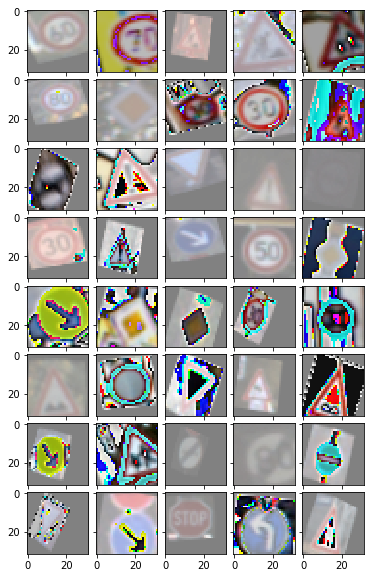

[37680, 50320, 93962, 121453, 78712, 62323, 77834, 20192, 58624, 3507, 117791, 112015, 66810, 61137, 45683, 72857, 37849, 34848, 128820, 36846, 98066, 113791, 117247, 88729, 71859, 105378, 32087, 2488, 24700, 65624, 17240, 24560, 30205, 25020, 15700, 109458, 68817, 25936, 89288, 111659]
[3, 4, 25, 25, 28, 5, 12, 1, 1, 25, 41, 18, 13, 18, 9, 1, 18, 38, 2, 12, 38, 12, 12, 1, 1, 22, 15, 13, 23, 22, 38, 28, 41, 6, 17, 13, 38, 14, 34, 24]


In [17]:
sample_locs = []
sample_labels = []
random_size = n_train


def normalize_grayscale(image_data, scale=1):
    
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/(( grayscale_max - grayscale_min ) * scale ))



def get_image(data, label):
    maybe_image = random.randint(0,random_size)
    sample_locs.append(maybe_image)
    sample_labels.append(label[maybe_image])
#    print('maybe_image %s: ' % maybe_image)
#    print('label value is %s' % label[maybe_image])
        
    return data[maybe_image]


fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                  )

for i in range(40):
    maybe_image = get_image(X_train, y_train)
#    grid[i].imshow(maybe_image) 
    X_normalized = normalize_grayscale(maybe_image, scale=0.6)
    grid[i].imshow(X_normalized) 
     # The AxesGrid object work as a list of axes.

plt.show()

print(sample_locs)
print(sample_labels)
#X_normalized = normalize_grayscale(X_train, scale=0.6)
#print(X_normalized.shape)
#print(X_train.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [18]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
#assert X_train.shape == data['features'].shape, 'X_train has changed shape. The shape shouldn\'t change when shuffling.'
#assert y_train.shape == data['labels'].shape, 'y_train has changed shape. The shape shouldn\'t change when shuffling.'

assert round(X_valid.shape[0]/n_train,2) == 0.2, 'X_train not splitted'
assert round(y_valid.shape[0]/n_train,2) == 0.2, 'y_train not splitted'
assert not np.array_equal(X_train, data['features']), 'X_train not shuffled.'
assert not np.array_equal(y_train, data['labels']), 'y_train not shuffled.'
print('Tests passed.')

AssertionError: X_train not splitted

1. shuffling
2. gray conversion
3. LeNet-5 architecture from the course
4. model layer evaluation (run each model whenever layer is added.)

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

implemented during 'exploratory visualization of the dataset' above 
: def normalize_grayscale(image_data, scale=1)

### Model Architecture

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

### Predict the Sign Type for Each Image

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In [ ]:
"""

from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

"""

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

In [ ]:
"""
data = load_pickle('train.p')

# TODO: Load the feature data to the variable X_train
X_train = data['features']
# TODO: Load the label data to the variable y_train
y_train = data['labels']

test = load_pickle('test.p')
X_test = test['features']
y_test = test['labels']

print('Training and Test data loaded.')
"""

In [ ]:
"""
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("number of classes ", n_classes)
#print("coords_train =", coords_train)
#print("size_train =", size_train)
"""

In [ ]:
"""
imagedir = "./data/"

X_web,y_web = load_resized_images_in_directory(32,32,imagedir)

print(X_web.shape)

show_image(X_web[1])

resize = resize_image(X_web[0],33,33) 

show_image(resize)

"""

In [ ]:
"""

imagedir = "./data/"

X_web,y_web = load_images_in_directory(imagedir)

print(X_web.shape)

show_image(X_web[1])

resize = resize_image(X_web[0],33,33) 

show_image(resize)

"""

In [ ]:
"""
fakes_label = make_fakes_labels(y_train,5)
print("fake labels - image label list, %s" % len(fakes_label))
print(fakes_label[0])
print(fakes_label[4])
print(fakes_label[190000])
print(fakes_label[190004])

y_train_norm = list_to_numpy(fakes_label)
print("numpy array converted from list, %s" % str(y_train_norm.shape))

save_pickle(y_train_norm,"y_train_norm.p")

label_norm = load_pickle('y_train_norm.p')
print(label_norm["features"].shape)
"""

In [ ]:
"""
fakes = make_fakes(X_train,5)
print("fakes - image list, %s" % len(fakes))

X_train_norm = list_to_numpy(fakes)
print("numpy array converted from list, %s" % str(X_train_norm.shape))

save_pickle(X_train_norm,"train_norm.p")

data_norm = load_pickle('train_norm.p')
print(data_norm["features"].shape)
"""

In [ ]:
"""
show_image(data_norm["features"][0])
show_image(data_norm["features"][3])
show_image(data_norm["features"][2])
"""